In [1]:
import numpy as np
import pandas as pd

train = pd.read_csv('/Users/alexbean/Desktop/Machine_Learning/Midterm/Data/train.csv')
val = pd.read_csv('/Users/alexbean/Desktop/Machine_Learning/Midterm/Data/val.csv')
test = pd.read_csv('/Users/alexbean/Desktop/Machine_Learning/Midterm/Data/test.csv')

print(train.shape)
print(val.shape)
print(test.shape)

# Number of labeled and unlabeled in the training data
print(f'Number of unlabeled data: {sum(train["Sentiment"] == -100)}')
print(f'Number of labeled data: {sum(train["Sentiment"] != -100)}')
unlabeled_i = 34948

(59706, 2)
(23256, 2)
(23257, 2)
Number of unlabeled data: 34948
Number of labeled data: 24758


# Data Processing

In [2]:
# print(train.isnull().sum())
# print(val.isnull().sum())
# print(test.isnull().sum())

train = train.fillna('')
val = val.fillna('')
test = test.fillna('')

print(train.isnull().sum())
print(val.isnull().sum())
print(test.isnull().sum())

Phrase       0
Sentiment    0
dtype: int64
Phrase       0
Sentiment    0
dtype: int64
Phrase      0
PhraseID    0
dtype: int64


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

In [ ]:
# Preprocess text

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocess 

# Preprocess function
def preprocess(df, text_column='Phrase'):
    df[text_column] = df[text_column].str.lower()
    df[text_column] = df[text_column].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))
    df[text_column] = df[text_column].apply(lambda x: re.sub(r'@\w+', '', x))
    df[text_column] = df[text_column].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))
    df[text_column] = df[text_column].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    df[text_column] = df[text_column].apply(lambda x: re.sub(r"[^a-zA-Z\s]", "", x))
    
    # Handle negations by replacing with full forms
    df[text_column] = df[text_column].apply(lambda x: re.sub(r"\b(can't|cannot)\b", 'can not', x))
    df[text_column] = df[text_column].apply(lambda x: re.sub(r"\b(n't)\b", ' not', x))
    df[text_column] = df[text_column].apply(lambda x: re.sub(r"\b(i'm)\b", 'i am', x))
    df[text_column] = df[text_column].apply(lambda x: re.sub(r"\b('ll|will)\b", ' will', x))
    df[text_column] = df[text_column].apply(lambda x: re.sub(r"\b('ve|have)\b", ' have', x))

    df[text_column] = df[text_column].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))
    df[text_column] = df[text_column].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))
    df[text_column] = df[text_column].apply(lambda x: re.sub(r"#(\S+)", lambda y: " ".join(re.findall(r"[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)", y.group(1))), x))
    
    # Remove excessive whitespace
    df[text_column] = df[text_column].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
    
    return df

In [5]:
# Apply preprocessing 

preprocess(train)
preprocess(test)
preprocess(val)

train_size_i = train.shape[0]

In [6]:
train.head()

labeled = train.copy()
labeled = labeled[labeled['Sentiment'] != -100]

## Bag of Words: Vectorization

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(min_df = 1, max_features = 10000)
train_vectorized = vectorizer.fit_transform(train['Phrase']).toarray()
val_vectorized = vectorizer.transform(val['Phrase']).toarray()
test_vectorized = vectorizer.transform(test['Phrase']).toarray()

## Priciple Component Analysis

This portion of code that is commented out was used to evaluate the optimal number of PCA components and KMeans clusters.

In [8]:
# import pandas as pd
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
# from sklearn.metrics import accuracy_score
# import concurrent.futures

# def pca_and_kmeans(train, val, test, n_components, cluster_counts):
#     """
#     Performs PCA transformation and KMeans clustering, returning the best results.
#     """
#     # Vectorization
#     vectorizer = CountVectorizer(min_df=1, max_features=10000)
#     train_vectorized = vectorizer.fit_transform(train['Phrase']).toarray()
    
#     # PCA Transformation
#     pca = PCA(n_components=n_components)
#     train_vectorized_PCA = pca.fit_transform(train_vectorized)

#     best_accuracy = 0
#     best_n_clusters = 0
#     best_predictions = None
    
#     # Loop through the defined range of cluster counts
#     for n_clusters in cluster_counts:
#         print(f"Testing KMeans with {n_clusters} clusters for PCA with {n_components} components...")
        
#         # Fit KMeans on the training data and predict clusters
#         kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
#         clusters = kmeans.fit_predict(train_vectorized_PCA)

#         # Map each cluster to the most common sentiment in that cluster
#         cluster_to_sentiment = train.groupby(clusters)['Sentiment'].agg(lambda x: x.value_counts().idxmax())

#         # Predict sentiment for each sample in the train set based on its cluster
#         predictions = pd.Series(clusters).map(cluster_to_sentiment)

#         # Calculate accuracy by comparing predicted sentiments with actual sentiments
#         accuracy = accuracy_score(train['Sentiment'], predictions)
#         print(f"Cluster-based accuracy for {n_clusters} clusters: {accuracy:.4f}")

#         # Update best accuracy and parameters if current is better
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_n_clusters = n_clusters
#             best_predictions = predictions

#     return n_components, best_n_clusters, best_predictions

# def test_pca_and_kmeans_multithreaded(train, val, test, min_components, max_components, step_components, cluster_counts):
#     best_accuracy = 0
#     best_n_components = 0
#     best_n_clusters = 0
#     overall_best_predictions = None

#     # Create a list to hold the futures
#     futures = []
    
#     # Limit to 3 concurrent threads
#     with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
#         for n_components in range(min_components, max_components + 1, step_components):
#             futures.append(executor.submit(pca_and_kmeans, train, val, test, n_components, cluster_counts))

#     for future in concurrent.futures.as_completed(futures):
#         n_components, best_n_clusters, best_predictions = future.result()
        
#         # Check if the current results are better than the overall best
#         accuracy = accuracy_score(train['Sentiment'], best_predictions) if best_predictions is not None else 0
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_n_components = n_components
#             best_n_clusters = best_n_clusters
#             overall_best_predictions = best_predictions

#     # Modify train DataFrame to keep the best results
#     train['Best_Cluster'] = KMeans(n_clusters=best_n_clusters).fit_predict(train_vectorized)
#     train['Best_Cluster_Prediction'] = overall_best_predictions

#     print(f"\nBest PCA Count: {best_n_components} with Best Cluster Count: {best_n_clusters} and accuracy: {best_accuracy:.4f}")

# # Example usage:
# test_pca_and_kmeans_multithreaded(train, val, test, min_components=25, max_components=350, step_components=25, cluster_counts=range(500, 1001, 500))

## Implement PCA

In [9]:
from sklearn.decomposition import PCA

n_components = 300
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(train_vectorized)

train_vectorized_PCA = pd.DataFrame(data = principalComponents, columns = [f'Component {i+1}' for i in range(n_components)])
val_vectorized_PCA = pd.DataFrame(data = pca.transform(val_vectorized), columns = [f'Component {i+1}' for i in range(n_components)])
test_vectorized_PCA = pd.DataFrame(data = pca.transform(test_vectorized), columns = [f'Component {i+1}' for i in range(n_components)])

train_vectorized_PCA.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Component 291,Component 292,Component 293,Component 294,Component 295,Component 296,Component 297,Component 298,Component 299,Component 300
0,-0.013331,0.213052,0.018458,-0.020201,-0.059764,0.009011,-0.114345,-0.079044,-0.061697,0.003071,...,0.013592,-0.010603,-0.014892,-0.001444,0.008329,-0.045119,0.019367,-0.014937,-0.025333,-0.026041
1,-0.086961,-0.142267,0.143872,-0.066438,0.002481,0.061604,-0.157679,0.058183,0.090638,-0.033103,...,0.001751,0.008338,0.027594,0.000836,0.002627,0.011361,-0.000249,-0.002369,0.015839,-0.012149
2,-0.017495,0.106656,-0.008467,-0.006805,-0.034321,0.003783,-0.061366,-0.050326,-0.045395,-0.015821,...,0.005364,-0.003292,0.005827,0.014441,-0.005026,0.006810,0.002764,0.005218,-0.000320,-0.012277
3,-0.027392,-0.007592,-0.010498,-0.012406,-0.017011,-0.014268,0.019115,0.000646,-0.030854,-0.013962,...,-0.000628,-0.004366,-0.000368,-0.005624,-0.006009,-0.012804,0.004292,0.001061,-0.004547,0.002010
4,-0.073972,-0.079325,0.228500,0.023172,-0.047065,-0.006849,-0.028313,-0.001247,0.033139,-0.071014,...,0.011219,0.004318,-0.028629,0.080196,0.012906,0.061565,-0.047259,0.074672,0.059693,0.011577


# Unsupervised Learning Methods

## KMeans

Observation: Clusters get more accurate and concentrated with fewer data points, i.e. more clusters.

In [10]:
# KMeans on the validation set

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

n_clusters = 1900
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
train['Cluster'] = kmeans.fit_predict(train_vectorized_PCA)

cluster_counts = train['Cluster'].value_counts()
print("Cluster Counts:\n", cluster_counts), print()

train.head()

Cluster Counts:
 Cluster
59      1719
639      270
575      206
394      203
1803     202
        ... 
67         1
1213       1
377        1
1367       1
229        1
Name: count, Length: 1900, dtype: int64



,Phrase,Sentiment,Cluster
0,mean need sleep satisfaction folding fitted sheet,-100,366
1,im sure whats disturbing fact theyre willing r...,-100,323
2,neon green jumpsuit plaid pant mean need profe...,-100,1275
3,good luck shut,-100,1734
4,clearly im functioning adul,1,916


In [11]:
# Assign unlabled data to the cluster with the most common label in the training data

# Function to replace -100 with the most frequent value in each cluster
def replace_negative_100_with_mode(df):
    clusters = df['Cluster'].unique()
    for cluster in clusters:
        cluster_data = df[df['Cluster'] == cluster]
        if -100 not in cluster_data['Sentiment'].values:
            continue
        valid_values = cluster_data['Sentiment'][cluster_data['Sentiment'] != -100]
        if valid_values.empty:
            # Delete the row if there are no valid values in the cluster
            df = df.drop(cluster_data.index)
            continue  # Skip this cluster or handle it as needed
        mode_value = cluster_data['Sentiment'][cluster_data['Sentiment'] != -100].mode()[0]
        df.loc[(df['Cluster'] == cluster) & (df['Sentiment'] == -100), 'Sentiment'] = mode_value
    return df

# Apply the function to the DataFrame
train = replace_negative_100_with_mode(train)

# Display the first few rows to verify the changes
print(train.shape)
train.head()

(58054, 3)


,Phrase,Sentiment,Cluster
0,mean need sleep satisfaction folding fitted sheet,1,366
1,im sure whats disturbing fact theyre willing r...,0,323
2,neon green jumpsuit plaid pant mean need profe...,2,1275
3,good luck shut,4,1734
4,clearly im functioning adul,1,916


In [12]:
# Add sentiment to vectorized data
train = train.drop(columns=['Cluster'])
train_size_f = train.shape[0]

# Print the number of points deleted
points_deleted = train_size_i - train_size_f
print(f"Points deleted: {points_deleted}")
# Percentage of points deleted
print(f"Percentage of points deleted: {(points_deleted / unlabeled_i) * 100:.2f}%")

Points deleted: 1652
Percentage of points deleted: 4.73%


# Supervised Learning

In [13]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress specific warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Helper function for evaluating a single model with specific parameters
def evaluate_model(model_name, model_func, train_features, dev_features, train_labels, dev_labels, m_value, max_features, max_iters):
    print(f"Starting {model_name} with M={m_value}, max_features={max_features}")
    best_f1_for_m = 0
    best_iterations_for_model = None
    
    for iterations in max_iters:
        if model_name in ['Logistic Regression (L2)', 'Softmax Regression']:
            model = model_func(iterations)
        else:
            model = model_func()
        
        model.fit(train_features, train_labels)
        dev_predictions = model.predict(dev_features)
        f1_dev = f1_score(dev_labels, dev_predictions, average='weighted')
        
        if f1_dev > best_f1_for_m:
            best_f1_for_m = f1_dev
            best_iterations_for_model = iterations
    
    print(f"Completed {model_name} with M={m_value}, max_features={max_features} - Best F1: {best_f1_for_m:.4f}")
    return model_name, m_value, max_features, best_f1_for_m, best_iterations_for_model

# Main function with multithreading
def find_best_performance(train_set, dev_set, m_values=range(1, 10), max_iters=range(50, 201, 10), max_features_values=[5000, 10000, 15000]):
    best_params = {}
    model_results = {
        'Logistic Regression (L2)': defaultdict(float),
        'Softmax Regression': defaultdict(float),
        'Multinomial Naive Bayes': defaultdict(float),
    }
    
    models = {
        'Logistic Regression (L2)': lambda iterations: LogisticRegression(max_iter=iterations, solver='liblinear', penalty='l2'),
        'Softmax Regression': lambda iterations: LogisticRegression(max_iter=iterations, solver='lbfgs'),  # Softmax Regression
        'Multinomial Naive Bayes': MultinomialNB,
    }
    
    best_overall_f1_score = 0
    best_model = None

    # Start multithreading
    with ThreadPoolExecutor() as executor:
        futures = []
        
        for M in m_values:
            vectorizer = TfidfVectorizer(min_df=M, max_features=max_features_values[-1])
            train_features = vectorizer.fit_transform(train_set['Phrase'])
            dev_features = vectorizer.transform(dev_set['Phrase'])
            train_labels = train_set['Sentiment']
            dev_labels = dev_set['Sentiment']
            
            for max_features in max_features_values:
                for model_name, model_func in models.items():
                    # Submit tasks to evaluate each model on a different thread
                    futures.append(executor.submit(
                        evaluate_model, model_name, model_func, train_features, dev_features,
                        train_labels, dev_labels, M, max_features, max_iters
                    ))
        
        # Collect results as threads complete
        for future in as_completed(futures):
            model_name, M, max_features, max_f1_for_m, best_iterations_for_model = future.result()
            
            # Print progress update for each completed task
            print(f"Finished evaluating {model_name} for M={M} and max_features={max_features}. Best F1: {max_f1_for_m:.4f}")
            
            if max_f1_for_m > best_overall_f1_score:
                best_overall_f1_score = max_f1_for_m
                best_model = model_name
                best_params = {'M': M, 'iterations': best_iterations_for_model, 'model': model_name, 'max_features': max_features}
            
            # Store the best F1 score for this M for each model
            if M not in model_results[model_name] or max_f1_for_m > model_results[model_name][M]:
                model_results[model_name][M] = max_f1_for_m  # update only with the highest F1 for each M

    print(f"\nBest Model: {best_model} with M = {best_params['M']}, Iterations = {best_params['iterations']}, Max Features = {best_params['max_features']}")
    print(f"Best F1 Score: {best_overall_f1_score:.4f}")

    # Wait for all threads to complete before plotting
    plt.figure(figsize=(12, 8))
    for model_name, results in model_results.items():
        m_values = sorted(results.keys())
        best_f1_scores = [results[m] for m in m_values]
        
        plt.plot(m_values, best_f1_scores, marker='o', label=f"{model_name} Best F1 vs. M")
        
    plt.title("F1 Score vs. M for Each Model")
    plt.xlabel("M - Value")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid()
    plt.show()

    return best_params, best_overall_f1_score

Starting Logistic Regression (L2) with M=1, max_features=1000Starting Softmax Regression with M=1, max_features=1000

Starting Multinomial Naive Bayes with M=1, max_features=1000
Starting Logistic Regression (L2) with M=1, max_features=5000
Starting Softmax Regression with M=1, max_features=5000
Starting Multinomial Naive Bayes with M=1, max_features=5000
Starting Logistic Regression (L2) with M=1, max_features=10000
Starting Softmax Regression with M=1, max_features=10000
Starting Multinomial Naive Bayes with M=1, max_features=10000
Starting Logistic Regression (L2) with M=1, max_features=15000
Starting Softmax Regression with M=1, max_features=15000
Starting Multinomial Naive Bayes with M=1, max_features=15000
Starting Logistic Regression (L2) with M=1, max_features=20000
Starting Softmax Regression with M=1, max_features=20000
Starting Multinomial Naive Bayes with M=1, max_features=20000
Completed Multinomial Naive Bayes with M=1, max_features=1000 - Best F1: 0.8929
Completed Multin

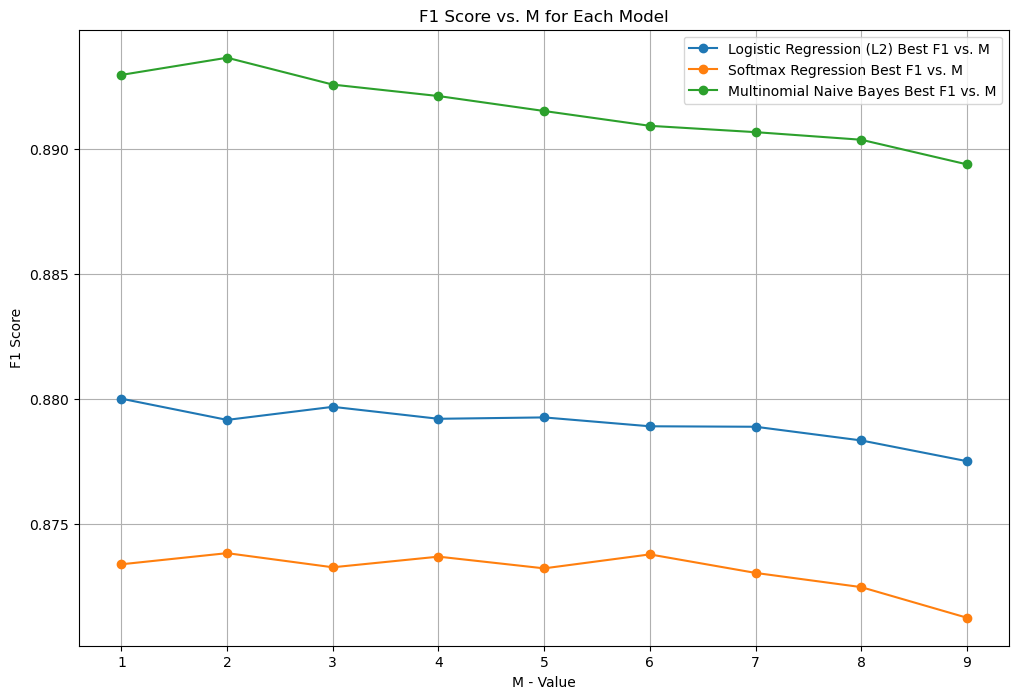

({'M': 2,
  'iterations': 50,
  'model': 'Multinomial Naive Bayes',
  'max_features': 1000},
 0.8936365257510532)

In [14]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Combine train and validation datasets

find_best_performance(train, val, m_values=range(1, 10), max_iters=range(50, 201, 100), max_features_values=[1000, 5000, 10000, 15000, 20000])

In [19]:
# Train the best model
# Multinomial Naive Bayes with M = 2, max_features = 5000

vectorizer = TfidfVectorizer(min_df = 2, max_features = 5000)
combined_train = pd.concat([train, val])
train_features = vectorizer.fit_transform(combined_train['Phrase'])
test_features = vectorizer.transform(test['Phrase'])

model = MultinomialNB(alpha = 0.5, fit_prior = False)
model.fit(train_features, combined_train['Sentiment'])
test_predictions = model.predict(test_features)

test_predictions_df = pd.DataFrame(test_predictions, columns=['Sentiment'])
test_predictions_df.head()

,Sentiment
0,3
1,2
2,4
3,1
4,4


In [20]:
# Assuming you want to add an index column to test_predictions_df
index_df = pd.DataFrame({'PhraseID': range(len(test_predictions_df))})
test_predictions_df = pd.concat([index_df, test_predictions_df], axis=1)

test_predictions_df.head()

,PhraseID,Sentiment
0,0,3
1,1,2
2,2,4
3,3,1
4,4,4


Save to CSV file

In [17]:
# test_predictions_df.to_csv('/submission.csv', index=False)

# Compare accuracy with addition of unsupervised labels

Starting Logistic Regression (L2) with M=1, max_features=1000
Starting Softmax Regression with M=1, max_features=1000
Starting Multinomial Naive Bayes with M=1, max_features=1000
Starting Logistic Regression (L2) with M=1, max_features=5000
Starting Softmax Regression with M=1, max_features=5000
Starting Multinomial Naive Bayes with M=1, max_features=5000
Starting Logistic Regression (L2) with M=1, max_features=10000
Starting Softmax Regression with M=1, max_features=10000
Starting Multinomial Naive Bayes with M=1, max_features=10000
Starting Logistic Regression (L2) with M=1, max_features=15000
Starting Softmax Regression with M=1, max_features=15000
Starting Multinomial Naive Bayes with M=1, max_features=15000
Starting Logistic Regression (L2) with M=1, max_features=20000
Starting Softmax Regression with M=1, max_features=20000
Starting Multinomial Naive Bayes with M=1, max_features=20000
Completed Multinomial Naive Bayes with M=1, max_features=15000 - Best F1: 0.8894
Completed Multi

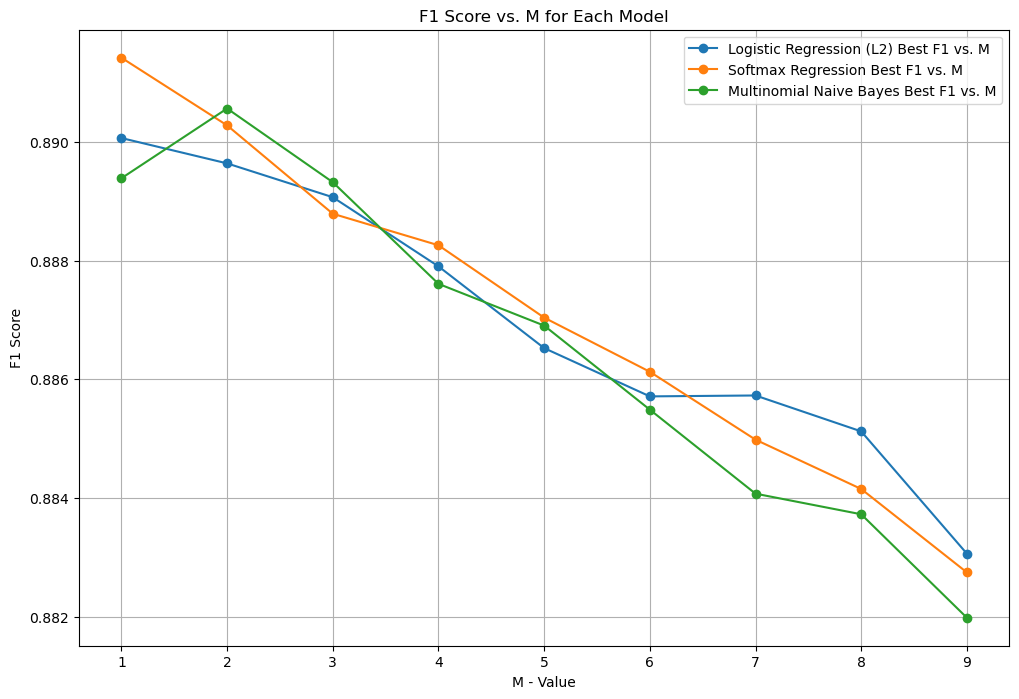

({'M': 1,
  'iterations': 150,
  'model': 'Softmax Regression',
  'max_features': 15000},
 0.8914141185958053)

In [18]:
# Check if labeled produces better results

find_best_performance(labeled, val, m_values=range(1, 10), max_iters=range(50, 201, 100), max_features_values=[1000, 5000, 10000, 15000, 20000])

## The performance using only the labeled data is comprable to using entire data set (with unsupervised labeling).

Labeled: 
- F1 Score = 0.8914
- Best model is Softmax Regression (M = 1)

Unsupervised labeling: 
- F1 Score = 0.8936
- Best model is Naive Bayes (M = 2)